# Convert df_events to meta dataframe for pyphotometry analysis
- Meant to be a bridge between the pyphotometry analysis and df_events for the time being 

In [38]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np
from trialexp.process.pycontrol.session_analysis import *
from trialexp.process.pycontrol.utils import *
from trialexp.process.pycontrol.plot_utils import *
from trialexp.process.pycontrol.session_analysis import Session
import sys
sys.path.append(r'../../../../pyControl')
import tools.data_import as di

## Read task definition

In [2]:
basefolder = r'C:\code\trialexp'
tasks = pd.read_csv(basefolder+'\\params\\tasks_params.csv', usecols=[1, 2, 3, 4], index_col=False)
task_name = 'reaching_go_spout_bar_nov22'

trial_window = [-2000, 4000]
timelim = [1000, 4000] # in ms

conditions, triggers, events_to_process = get_task_specs(tasks,  task_name)
print(triggers)

['hold_for_water']


## Read pycontrol file

In [3]:

pycontrol_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\'
filename = 'kms062-2023-02-06-112451'
smrx_output_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\processed\\'
# df_session = di.session_dataframe(pycontrol_dir+filename+'.txt')


filename = r'Z:\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22\kms058-2023-02-20-120453.txt'

df_session = di.session_dataframe(filename)
df_pycontrol = parse_session_dataframe(df_session, conditions)


Importing data file: kms058-2023-02-20-120453.txt


In [4]:
from datetime import datetime
session_time = datetime.strptime(df_pycontrol.attrs['Start date'], '%Y/%m/%d %H:%M:%S')
subjectID = df_pycontrol.attrs['Subject ID']

## Extract trial-related information from events

In [5]:
df_events_trials, df_events = extract_trial_by_trigger(df_pycontrol, triggers[0], conditions+events_to_process, 
                                            trial_window, subjectID, session_time)
df_events_trials.head()

,US_end_timer_trial_time,bar_trial_time,bar_off_trial_time,busy_win_timer_trial_time,button_press_trial_time,spout_trial_time,waiting_for_spout_trial_time,water by bar_off_trial_time,water by spout_trial_time,water_on_trial_time,trial_nb,uid,timestamp,trigger,valid
trial_nb,,,,,,,,,,,,,,,
1.0,"[1805.0, 1993.0]","[371.0, 997.0, 1108.0, 1152.0, 1185.0]","[320.0, 965.0, 1013.0, 1123.0, 1168.0, 1200.0]",NaN,NaN,"[1285.0, 1473.0, 1786.0, 1974.0, 2160.0, 3825.0]",[100.0],NaN,"[1786.0, 1974.0]","[1786.0, 1974.0]",1.0,kms058_2023-02-20_12:04:53_1.0,8417.0,hold_for_water,True
2.0,"[985.0, 1438.0]",[316.0],"[295.0, 331.0]",NaN,NaN,"[465.0, 918.0, 1275.0, 2399.0]",[100.0],NaN,"[966.0, 1419.0]","[966.0, 1419.0]",2.0,kms058_2023-02-20_12:04:53_2.0,22716.0,hold_for_water,True
3.0,"[968.0, 1468.0]",[-1963.0],[334.0],NaN,NaN,"[448.0, 948.0, 1287.0, 1449.0]",[100.0],NaN,"[949.0, 1449.0]","[949.0, 1449.0]",3.0,kms058_2023-02-20_12:04:53_3.0,35804.0,hold_for_water,True
4.0,"[1106.0, 1324.0]",[-1963.0],[498.0],NaN,NaN,"[585.0, 804.0, 1087.0, 1305.0, 1431.0]",[100.0],NaN,"[1087.0, 1305.0]","[1087.0, 1305.0]",4.0,kms058_2023-02-20_12:04:53_4.0,49094.0,hold_for_water,True
5.0,"[1284.0, 1976.0]",NaN,[668.0],NaN,NaN,"[764.0, 1456.0, 1957.0, 3456.0]",[100.0],NaN,"[1265.0, 1957.0]","[1265.0, 1957.0]",5.0,kms058_2023-02-20_12:04:53_5.0,59424.0,hold_for_water,True


## Compute conditions:

In [6]:
df_conditions = compute_conditions_by_trial(df_events_trials, conditions)

## Compute success based on definition

In [7]:
df_conditions = compute_success(df_events_trials, df_conditions, task_name)

In [8]:
df_conditions

,uid,trigger,valid,US_end_timer,water_on,water by bar_off,water by spout,water for free,water success,busy_win_timer,spout,button_press,waiting_for_spout,success
trial_nb,,,,,,,,,,,,,,
1.0,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,True,True,False,True,False,False,False,True,False,True,True
2.0,kms058_2023-02-20_12:04:53_2.0,hold_for_water,True,True,True,False,True,False,False,False,True,False,True,True
3.0,kms058_2023-02-20_12:04:53_3.0,hold_for_water,True,True,True,False,True,False,False,False,True,False,True,True
4.0,kms058_2023-02-20_12:04:53_4.0,hold_for_water,True,True,True,False,True,False,False,False,True,False,True,True
5.0,kms058_2023-02-20_12:04:53_5.0,hold_for_water,True,True,True,False,True,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176.0,kms058_2023-02-20_12:04:53_176.0,hold_for_water,True,False,False,False,False,False,False,False,False,False,True,False
177.0,kms058_2023-02-20_12:04:53_177.0,hold_for_water,True,False,False,False,False,False,False,False,False,False,True,False
178.0,kms058_2023-02-20_12:04:53_178.0,hold_for_water,True,False,False,False,False,False,False,False,False,False,True,False


## Plotting

In [9]:
df_events_cond = df_events.merge(df_conditions, on='trial_nb')

In [10]:
df_events_cond

,type,name,time,value,trial_nb,trial_time,trigger_x,uid,trigger_y,valid,...,water_on,water by bar_off,water by spout,water for free,water success,busy_win_timer,spout,button_press,waiting_for_spout,success
0,state,waiting_for_spout,8517.0,NaN,1.0,100.0,hold_for_water,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,...,True,False,True,False,False,False,True,False,True,True
1,event,bar_off,8737.0,NaN,1.0,320.0,hold_for_water,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,...,True,False,True,False,False,False,True,False,True,True
2,event,bar,8788.0,NaN,1.0,371.0,hold_for_water,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,...,True,False,True,False,False,False,True,False,True,True
3,event,bar_off,9382.0,NaN,1.0,965.0,hold_for_water,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,...,True,False,True,False,False,False,True,False,True,True
4,event,bar,9414.0,NaN,1.0,997.0,hold_for_water,kms058_2023-02-20_12:04:53_1.0,hold_for_water,True,...,True,False,True,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,state,waiting_for_spout,2350881.0,NaN,178.0,200.0,hold_for_water,kms058_2023-02-20_12:04:53_178.0,hold_for_water,True,...,False,False,False,False,False,False,False,False,True,False
1899,state,waiting_for_spout,2365686.0,NaN,179.0,200.0,hold_for_water,kms058_2023-02-20_12:04:53_179.0,hold_for_water,True,...,False,False,False,False,False,False,False,False,True,False
1900,state,waiting_for_spout,2383465.0,NaN,180.0,200.0,hold_for_water,kms058_2023-02-20_12:04:53_180.0,hold_for_water,True,...,False,False,False,False,False,False,False,False,True,False
1901,event,bar_off,2384944.0,NaN,180.0,1679.0,hold_for_water,kms058_2023-02-20_12:04:53_180.0,hold_for_water,True,...,False,False,False,False,False,False,False,False,True,False


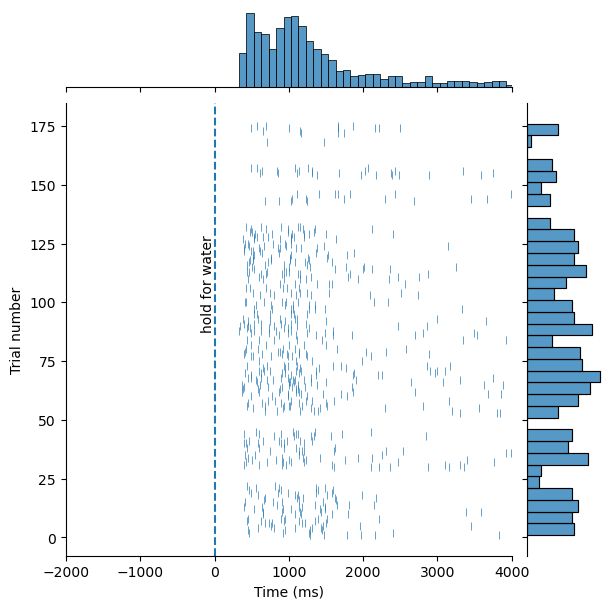

In [43]:
#Plot the event plots
df2plot = df_events_cond[df_events_cond.name=='spout']
g = plot_event_distribution(df2plot, 'trial_time', 'trial_nb', ybinwidth=5, xlim=[trial_window[0], trial_window[1]])
trigger_text = triggers[0].replace('_', ' ')
style_event_distribution(g, 'Time (ms)', 'Trial number', trigger_text)
